## Importing Dependencies and Data

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from glob import glob
import numpy as np
import torch

In [ ]:
def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
DEVICE = set_device()

GPU is enabled in this notebook.


In [ ]:
image_path = "African Prints/"
images = glob(image_path + "*.jpg")
len(images)

790

In [ ]:
images

['African Prints/1193.jpg',
 'African Prints/1798.jpg',
 'African Prints/1320.jpg',
 'African Prints/1210.jpg',
 'African Prints/1566.jpg',
 'African Prints/1200.jpg',
 'African Prints/1717.jpg',
 'African Prints/1618.jpg',
 'African Prints/1267.jpg',
 'African Prints/1312.jpg',
 'African Prints/1169.jpg',
 'African Prints/1547.jpg',
 'African Prints/1329.jpg',
 'African Prints/1737.jpg',
 'African Prints/1818.jpg',
 'African Prints/1410.jpg',
 'African Prints/1660.jpg',
 'African Prints/1293.jpg',
 'African Prints/1710.jpg',
 'African Prints/1411.jpg',
 'African Prints/1337.jpg',
 'African Prints/1372.jpg',
 'African Prints/1365.jpg',
 'African Prints/1828.jpg',
 'African Prints/1363.jpg',
 'African Prints/1255.jpg',
 'African Prints/1666.jpg',
 'African Prints/1467.jpg',
 'African Prints/1155.jpg',
 'African Prints/1601.jpg',
 'African Prints/1449.jpg',
 'African Prints/1514.jpg',
 'African Prints/1107.jpg',
 'African Prints/1705.jpg',
 'African Prints/1128.jpg',
 'African Prints/132

## Visualizing Data

In [ ]:
import numpy as np

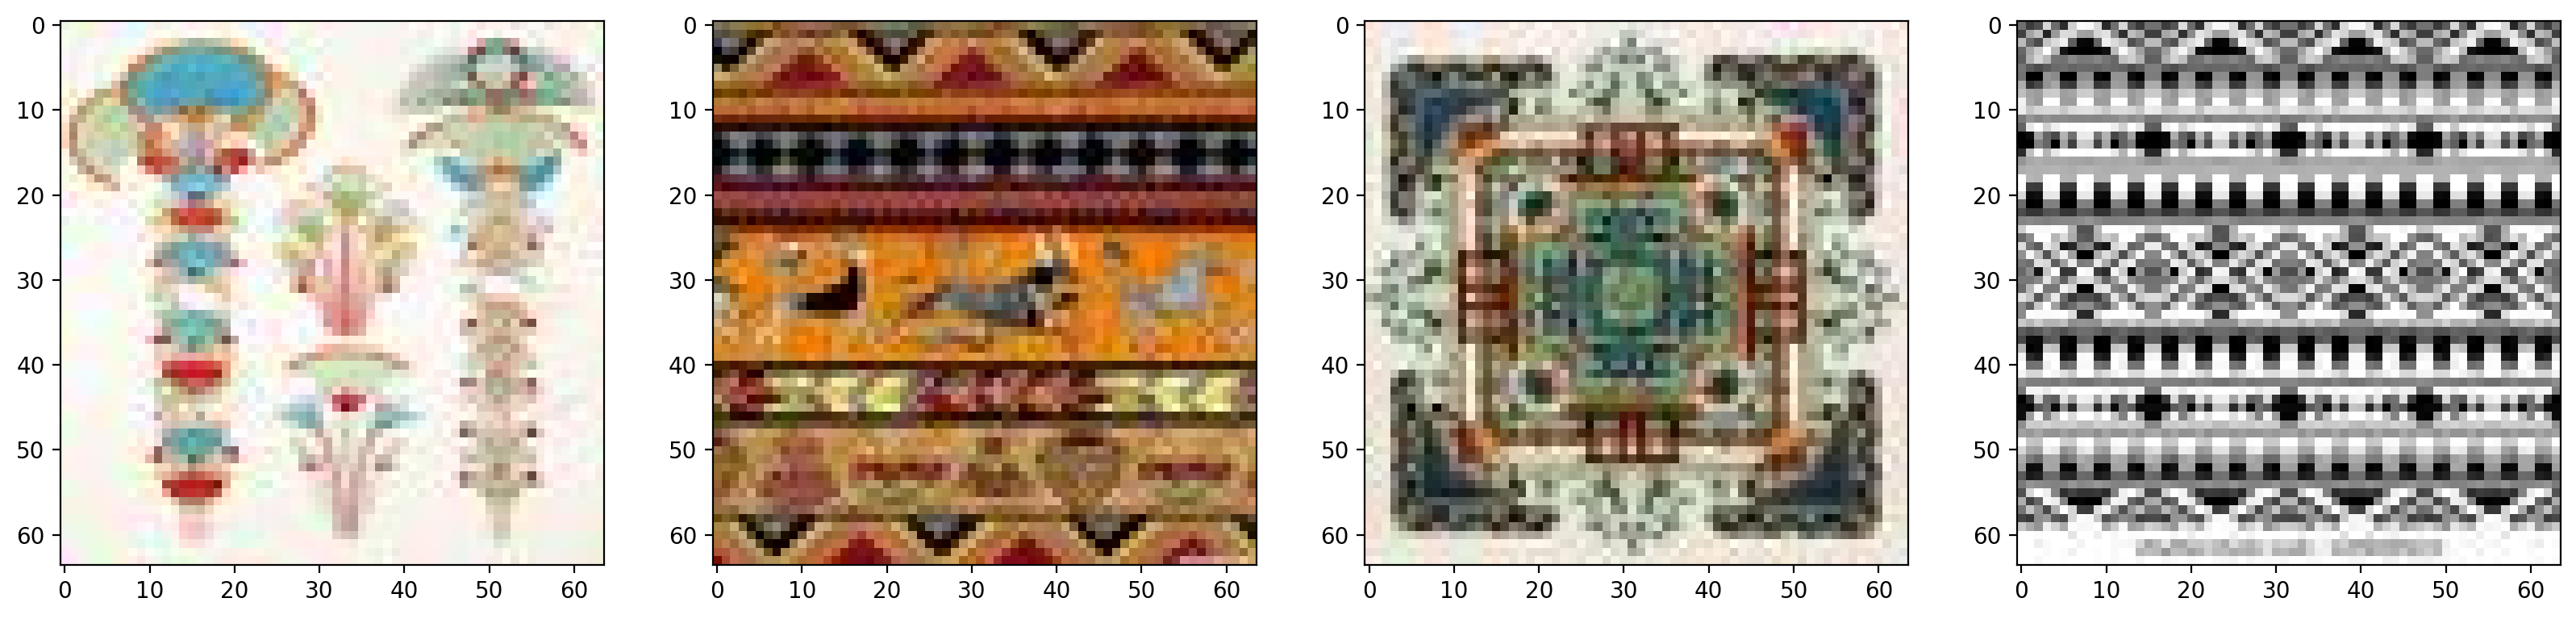

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20), dpi=200)
for index in range(4):
    image = cv2.imread(images[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[index].imshow(np.squeeze(image))


## Preprocessing Images

#### Scaling images to values between 0 and 1

In [ ]:
def scale_images(image_path):
  # Read the image from the file path
  image_string = tf.io.read_file(image_path)
  # Decode the image (adjust decoding based on image format)
  image = tf.image.decode_jpeg(image_string, channels=3)  # Assuming JPEG format
  # Scale the image to a range of [0, 1]
  image = tf.cast(image, tf.float32) / 255.0
  return image




In [ ]:
# Create a TensorFlow Dataset from the image paths
dataset = tf.data.Dataset.from_tensor_slices(images)

# Apply the `scale_images` function to each image path
dataset = dataset.map(scale_images)

# Shuffling helps with randomization during training
dataset = dataset.shuffle(buffer_size=len(images))  # Set buffer size to number of images

# Batch into 128 images per sample
dataset = dataset.batch(128)

# Reduces the likelihood of bottlenecking (optional)
# Prefetching helps overlap data loading with training
dataset = dataset.prefetch(tf.data.AUTOTUNE)


In [ ]:
dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None)>

In [ ]:
dataset.as_numpy_iterator().next().shape

(128, 64, 64, 3)

## Building the Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

#### Building Generator

In [ ]:
def build_generator():
    model = Sequential()

    model.add(Dense(8*8*256, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((8,8,256)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, (5,5), padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(64, (5,5), padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 3
    model.add(UpSampling2D())
    model.add(Conv2D(32, (5,5), padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    #model.add(Conv2D(128, (5,5), padding='same'))
    #model.add(LeakyReLU(0.2))

    # Convolutional block 2
    #model.add(Conv2D(64, (5,5), padding='same'))
    #model.add(LeakyReLU(0.2))

    # Final convolution layer to get to three channels
    model.add(Conv2D(3, (5,5), padding='same', activation='sigmoid'))



    return model

In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             2113536   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 16, 16, 256)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 128)       819328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                        

#### Testing the Generator

In [ ]:
img = generator.predict(np.random.randn(4,128))


1/1 [==============================] - 2s 2s/step


In [ ]:
print(img.shape)
print(type(img))

(4, 64, 64, 3)
<class 'numpy.ndarray'>


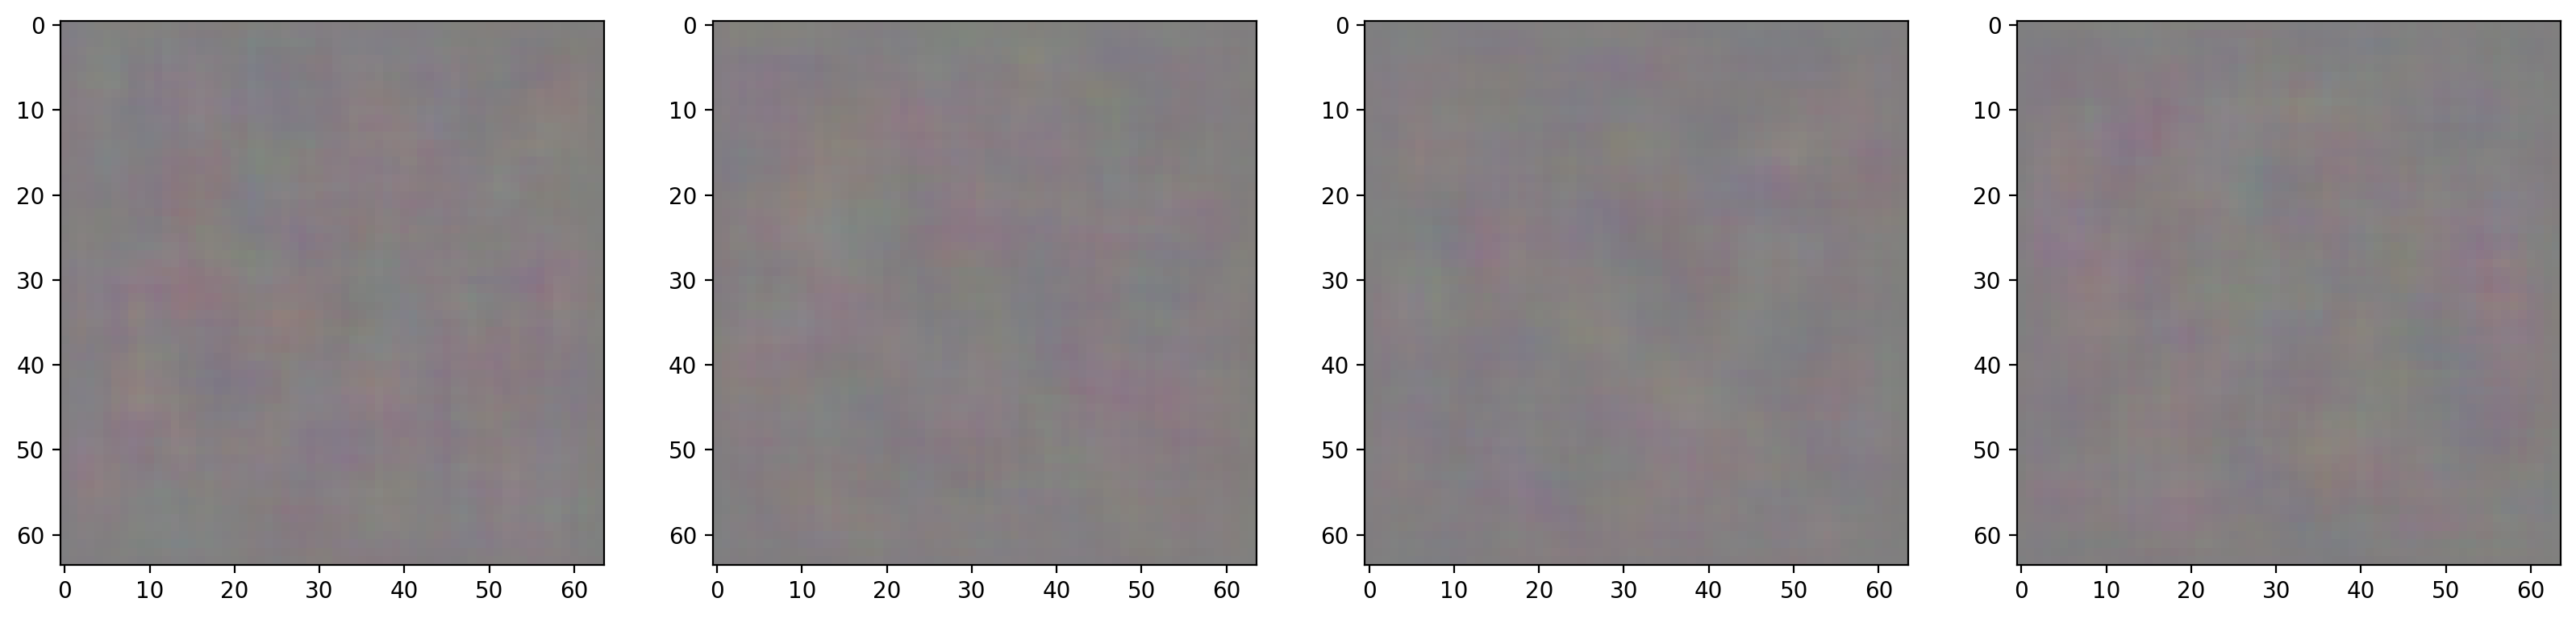

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20), dpi=200)
for index, img in enumerate(img):
    ax[index].imshow(np.squeeze(img))

#### Building the Discriminator

In [ ]:
def build_discriminator():
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(32, 5, input_shape=(64,64,3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Convolutional Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Convolutional Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Convolutional Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to Dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))


    return model

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 60, 60, 32)        0         
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)        51264     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 56, 56, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)      

In [ ]:
img.shape

(64, 64, 3)

In [ ]:
expanded_img = np.expand_dims(img, axis=0)

In [ ]:
expanded_img.shape

(1, 64, 64, 3)

In [ ]:
discriminator.predict(expanded_img)

1/1 [==============================] - 0s 363ms/step


array([[0.4750073]], dtype=float32)

#### Defining the Training Loop

#### Setting up the losses and optimizers

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
generator_optimizer = Adam(learning_rate=0.0001)
discriminator_optimizer = Adam(learning_rate=0.00001)

generator_loss = BinaryCrossentropy()
discriminator_loss = BinaryCrossentropy()

#### Building subclassed model

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
class AfricanPrintGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Create attributes for generator and discriminator
        self.generator = generator
        self.discriminator = discriminator


    def compile(self, generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss


    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Training the discriminator
        with tf.GradientTape() as d_tape:
            # Pass real and fake images to the discriminator
            predicted_real = self.discriminator(real_images, training=True)
            predicted_fake = self.discriminator(fake_images, training=True)
            predicted_realfake = tf.concat([predicted_real, predicted_fake], axis=0)

            # Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(predicted_real), tf.ones_like(predicted_fake)], axis=0)

            # Add some noise to outputs to confuse model
            noise_real = 0.5*tf.random.uniform(tf.shape(predicted_real))
            noise_fake = -0.5*tf.random.uniform(tf.shape(predicted_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            #Calculate loss
            total_discriminator_loss = self.discriminator_loss(y_realfake, predicted_realfake)

        # Applying backpropagation
        discriminator_grad = d_tape.gradient(total_discriminator_loss, self.discriminator.trainable_variables)
        self.discriminator_optimizer.apply_gradients(zip(discriminator_grad, self.discriminator.trainable_variables))


        # Training the Generator
        with tf.GradientTape() as g_tape:
            # Generate new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss
            total_generator_loss = self.generator_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Applying backpropagation
        generator_grad = g_tape.gradient(total_generator_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(generator_grad, self.generator.trainable_variables))

        return {"Discriminator_loss = ":total_discriminator_loss, "Generator_loss = ":total_generator_loss}

    def test_step(self):
        pass

Creating instance of the subclassed model

In [ ]:
african_print_gan = AfricanPrintGAN(generator, discriminator)

In [ ]:
african_print_gan.compile(generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss)

#### Building Callback

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('generated_images', f'generated_img_{epoch}_{i}.jpg'))

#### Training process

In [ ]:
hist = african_print_gan.fit(dataset, epochs=500, callbacks=[ModelMonitor()])

Epoch 1/500
6/7 [========================>.....] - ETA: 0s - Discriminator_loss = : 0.6969 - Generator_loss = : 0.7125

7/7 [==============================] - 41s 1s/step - Discriminator_loss = : 0.6984 - Generator_loss = : 0.7142
Epoch 2/500
7/7 [==============================] - 3s 423ms/step - Discriminator_loss = : 0.6996 - Generator_loss = : 0.7202
Epoch 3/500
7/7 [==============================] - 3s 422ms/step - Discriminator_loss = : 0.7081 - Generator_loss = : 0.6731
Epoch 4/500
7/7 [==============================] - 3s 423ms/step - Discriminator_loss = : 0.7027 - Generator_loss = : 0.7165
Epoch 5/500
7/7 [==============================] - 3s 423ms/step - Discriminator_loss = : 0.6793 - Generator_loss = : 0.8514
Epoch 6/500
7/7 [==============================] - 3s 422ms/step - Discriminator_loss = : 0.6381 - Generator_loss = : 0.9319
Epoch 7/500
7/7 [==============================] - 3s 423ms/step - Discriminator_loss = : 0.6058 - Generator_loss = : 1.0135
Epoch 8/500
7/7 [==============================] - 3s 420ms/step - Discriminator_loss = : 0.7263 - Generator_loss = : 0.5707
Epoch 9/500
7/

#### Reviewing Performance of Model

In [ ]:
hist.history

{'Discriminator_loss = ': [0.7026989459991455,
  0.7007063031196594,
  0.7533645033836365,
  0.6818315386772156,
  0.6314705610275269,
  0.6068466901779175,
  0.6100916266441345,
  0.8986682295799255,
  0.6810969710350037,
  0.6252453923225403,
  0.7358077168464661,
  0.652107834815979,
  0.6339962482452393,
  0.641372561454773,
  0.6669675707817078,
  0.634352445602417,
  0.6376545429229736,
  0.6380947232246399,
  0.6400874853134155,
  0.6304250955581665,
  0.6436268091201782,
  0.6421676874160767,
  0.6381809711456299,
  0.6315935254096985,
  0.6312531232833862,
  0.6353267431259155,
  0.6273540258407593,
  0.6463429927825928,
  0.6239121556282043,
  0.6184478998184204,
  0.6314534544944763,
  0.6287912726402283,
  0.6363475322723389,
  0.6398031711578369,
  0.6984108686447144,
  0.692450225353241,
  0.6720407009124756,
  0.6803802251815796,
  0.6729573607444763,
  0.6813479065895081,
  0.6789389252662659,
  0.6768964529037476,
  0.6738053560256958,
  0.6750766634941101,
  0.6706534

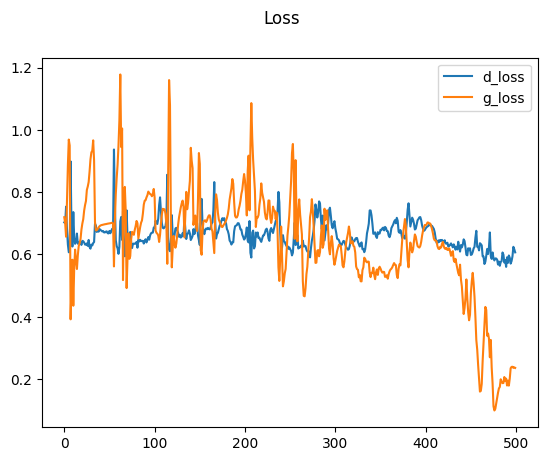

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['Discriminator_loss = '], label='d_loss')
plt.plot(hist.history['Generator_loss = '], label='g_loss')
plt.legend()
plt.show()

#### Generating Images

In [ ]:
imgs = generator.predict(tf.random.normal((8,128)))
imgs

1/1 [==============================] - 0s 298ms/step


array([[[[0.56755465, 0.50692225, 0.2605969 ],
         [0.49624488, 0.53225493, 0.21471444],
         [0.70732075, 0.722446  , 0.65015024],
         ...,
         [0.48195377, 0.48945805, 0.48352423],
         [0.5136425 , 0.53523946, 0.52075225],
         [0.53362197, 0.546813  , 0.53238124]],

        [[0.71906966, 0.46019706, 0.28366613],
         [0.7122726 , 0.4541795 , 0.32744586],
         [0.93570733, 0.725082  , 0.9181059 ],
         ...,
         [0.5613324 , 0.40974993, 0.49468037],
         [0.5958046 , 0.47897738, 0.5620423 ],
         [0.5686775 , 0.51060826, 0.5577803 ]],

        [[0.7858958 , 0.3346717 , 0.2533974 ],
         [0.7959825 , 0.5442322 , 0.46982175],
         [0.98371774, 0.9325935 , 0.98490506],
         ...,
         [0.7077385 , 0.45549574, 0.5737973 ],
         [0.73891664, 0.51610106, 0.65489215],
         [0.6758496 , 0.5545002 , 0.62445617]],

        ...,

        [[0.6038687 , 0.5501041 , 0.45918468],
         [0.5903584 , 0.65996605, 0.49991757]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
!zip -r dataset.zip generated_images/

  adding: generated_images/ (stored 0%)
  adding: generated_images/generated_img_198_0.jpg (deflated 13%)
  adding: generated_images/generated_img_242_1.jpg (deflated 11%)
  adding: generated_images/generated_img_41_0.jpg (deflated 16%)
  adding: generated_images/generated_img_451_1.jpg (deflated 7%)
  adding: generated_images/generated_img_72_1.jpg (deflated 15%)
  adding: generated_images/generated_img_445_1.jpg (deflated 7%)
  adding: generated_images/generated_img_318_1.jpg (deflated 8%)
  adding: generated_images/generated_img_287_2.jpg (deflated 10%)
  adding: generated_images/generated_img_486_0.jpg (deflated 7%)
  adding: generated_images/generated_img_37_2.jpg (deflated 16%)
  adding: generated_images/generated_img_209_0.jpg (deflated 15%)
  adding: generated_images/generated_img_189_1.jpg (deflated 14%)
  adding: generated_images/generated_img_151_0.jpg (deflated 15%)
  adding: generated_images/generated_img_35_2.jpg (deflated 14%)
  adding: generated_images/generated_img_436

In [44]:
from google.colab import files
files.download('dataset.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Plotting of Generated Images

In [45]:
generated_images_path = "generated_images/"
generated_pictures = glob(generated_images_path + "*.jpg")
len(generated_pictures)

1500

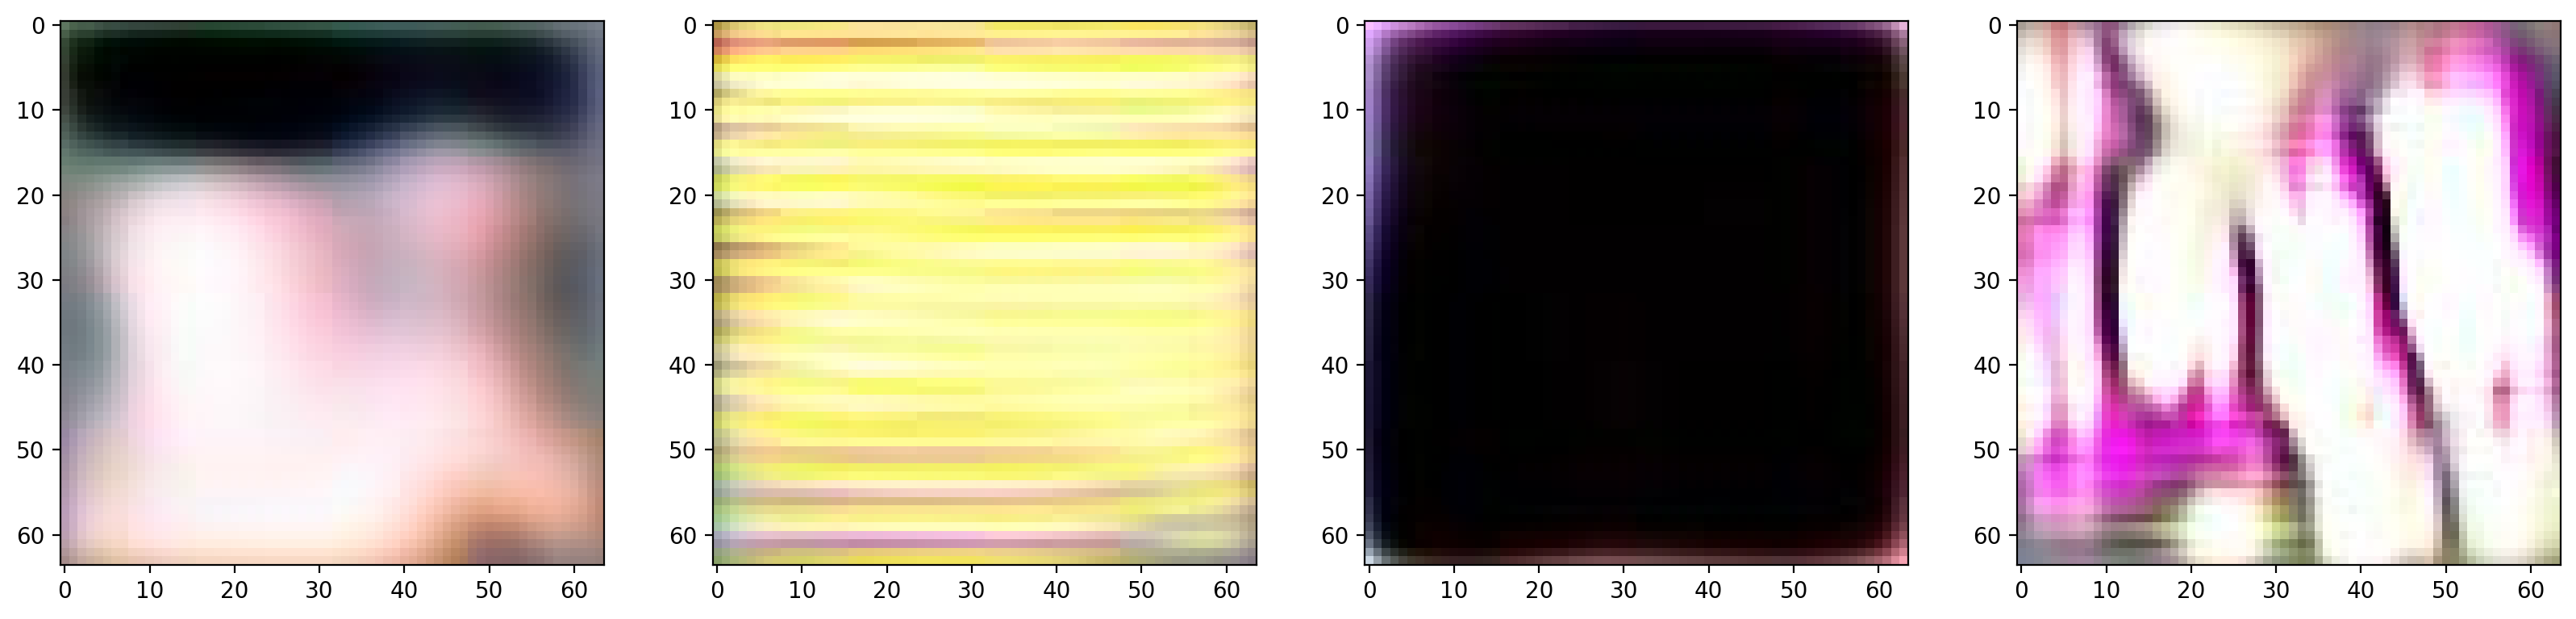

In [46]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20), dpi=200)
for index in range(4):
    image = cv2.imread(generated_pictures[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[index].imshow(np.squeeze(image))
